In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import random

from arithmetic_lm.model import load_model, generate
from arithmetic_lm.tokenizer import CharTokenizer
from arithmetic_lm.constants import PLOTS_DIR, CHECKPOINTS_DIR
from arithmetic_lm.utils import get_carry_str

import warnings

warnings.filterwarnings("ignore")

plt.style.use("../figure.mplstyle")

In [3]:
tokenizer = CharTokenizer()
stop_token = tokenizer.encode("$")[0]

In [4]:
def load_model(
    ckpt_path: str, model_class: str = "TransformerDecoder", map_location: str = "mps"
) -> tuple[torch.nn.Module, dict]:
    from arithmetic_lm.model import MODELS

    # load model
    ckpt = torch.load(ckpt_path, map_location=map_location)
    model = MODELS[model_class](
        **ckpt["hyper_parameters"]["model_hparams"],
        # vocab_size=tokenizer.vocab_size,
    )
    # TODO HACK remove transformer_encoder from prefix
    ckpt["state_dict"] = {
        k.replace("transformer_encoder.", ""): v for k, v in ckpt["state_dict"].items()
    }

    # state dict has a prefix "model." in the key names
    model.load_state_dict(
        {k[6:]: v for k, v in ckpt["state_dict"].items() if k.startswith("model.")},
        strict=False,
    )
    model.eval()
    return model, ckpt["hyper_parameters"]

In [5]:
# load model
ckpt_path = "../checkpoints/addition-generalize-to-longer/trans_dec_6layers_768embd_4head_randsp0.5_rev_ansloss/step1000000-train_loss0.0002-val_loss0.0000.ckpt"
model, hparams = load_model(ckpt_path)
model.to("mps")
model.eval()

TransformerDecoder(
  (embedding): Embedding(100, 768)
  (pos_encoder): AbsolutePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (layers): ModuleList(
    (0-5): 6 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (lm_head): Linear(in_features=768, out_features=100, bias=False)
)

In [6]:
print(hparams["extra_hparams"]["data_format"])
reverse_ops = hparams["extra_hparams"]["data_format"]["reverse_ops"]
reverse_ans = hparams["extra_hparams"]["data_format"]["reverse_ans"]

{'pad': '$', 'pad_ops_zero': None, 'pad_ans_zero': None, 'reverse_ops': True, 'reverse_ans': True, 'encdec': False, 'filler_tokens_prompt': 0, 'filler_tokens_ans': 0, 'operand_random_spaces_amount': 0.5, 'chain_of_thought': False}


In [28]:
def plot(ax, digit_length, n_samples, seed=1337, xlabel=True, legend=True):
    entropies = []
    eos_probs = []
    correct_token_probs = []

    eos_token_id = tokenizer.encode("$")[0]

    max_new_tokens = digit_length + 5

    random.seed(seed)

    for _ in tqdm(range(n_samples)):
        # Generate random numbers
        a = random.randint(10 ** (digit_length - 1), 10**digit_length - 1)
        b = random.randint(10 ** (digit_length - 1), 10**digit_length - 1)

        # Reverse operands if needed
        if reverse_ops:
            a_str = str(a)[::-1]
            b_str = str(b)[::-1]
        else:
            a_str = str(a)
            b_str = str(b)

        prompt = f"${a_str}+{b_str}="

        # Encode prompt
        prompt_idx = tokenizer.encode(prompt, return_tensors=True).to("mps")

        # Generate the true answer
        ans = a + b
        if reverse_ans:
            ans_str = str(ans)[::-1]
        else:
            ans_str = str(ans)
        ans_str += "$"

        # Generate model output with logits
        pred_idx, pred_logits = generate(
            model,
            prompt_idx,
            max_new_tokens=max_new_tokens,
            stop_token=eos_token_id,
            return_logits=True,
        )

        pred_logits = torch.tensor(pred_logits).to("mps")

        # Number of generated tokens
        num_generated_tokens = pred_idx.shape[1]

        # Now compute probabilities and entropy
        probs = torch.softmax(
            pred_logits, dim=-1
        )  # Shape: (num_generated_tokens, vocab_size)

        # Calculate entropy for each token
        entropy = -(probs * torch.log(probs + 1e-12)).sum(
            dim=-1
        )  # Shape: (num_generated_tokens,)

        # Pad entropy sequence to max_new_tokens
        entropy_seq = entropy.cpu().numpy()
        entropy_padded = np.full((max_new_tokens,), np.nan)
        entropy_padded[:num_generated_tokens] = entropy_seq

        # Append entropy sequence to list
        entropies.append(entropy_padded)

        # Extract logit for EOS token
        eos_prob_seq = probs[:, eos_token_id].cpu().numpy()
        eos_prob_padded = np.full((max_new_tokens,), np.nan)
        eos_prob_padded[:num_generated_tokens] = eos_prob_seq
        eos_probs.append(eos_prob_padded)

        # Calculate the probability of the correct token at each position
        correct_token_ids = tokenizer.encode(ans_str, return_tensors=True).to("mps")
        maxlen = min(correct_token_ids.shape[0], num_generated_tokens)
        correct_token_prob_seq = (
            probs[range(maxlen), correct_token_ids[:maxlen]].cpu().numpy()
        )

        # Pad correct token probability sequence
        correct_token_prob_seq = np.array(correct_token_prob_seq)
        correct_token_prob_padded = np.full((max_new_tokens,), np.nan)
        correct_token_prob_padded[:maxlen] = correct_token_prob_seq

        # Append correct token probabilities to list
        correct_token_probs.append(correct_token_prob_padded)

    # Now compute mean and std over entropies, EOS logits, and correct token probabilities, ignoring NaNs
    entropies = np.array(entropies)  # Shape: (n_samples, max_new_tokens)
    eos_probs = np.array(eos_probs)  # Shape: (n_samples, max_new_tokens)
    correct_token_probs = np.array(
        correct_token_probs
    )  # Shape: (n_samples, max_new_tokens)

    mean_entropy = np.nanmean(entropies, axis=0)
    std_entropy = np.nanstd(entropies, axis=0)

    mean_eos_prob = np.nanmean(eos_probs, axis=0)
    std_eos_prob = np.nanstd(eos_probs, axis=0)

    mean_correct_token_prob = np.nanmean(correct_token_probs, axis=0)
    std_correct_token_prob = np.nanstd(correct_token_probs, axis=0)

    # Plot mean entropy with shaded std deviation
    positions = range(1, max_new_tokens + 1)

    # title
    ax.set_title(f"{digit_length}-digit operands")

    # set xticks
    ax.set_xticks(positions[::5])
    ax.set_xticklabels(positions[::5])

    if xlabel:
        ax.set_xlabel("Token position in generated sequence")

    ax.set_ylabel("Entropy")
    (entropy_line,) = ax.plot(
        positions, mean_entropy, "-o", label="Mean entropy", color="blue"
    )
    entropy_fill = ax.fill_between(
        positions,
        np.clip(mean_entropy - std_entropy, 0, None),
        mean_entropy + std_entropy,
        color="blue",
        alpha=0.2,
    )

    # Add EOS probabilities on second y-axis (ax2)
    ax2 = ax.twinx()  # Instantiate a second axes that shares the same x-axis
    ax2.set_ylabel("Probability")  # We already handled the x-label with ax
    (eos_line,) = ax2.plot(
        positions, mean_eos_prob, "-o", label="Mean EOS prob", color="red"
    )
    eos_fill = ax2.fill_between(
        positions,
        np.clip(mean_eos_prob - std_eos_prob, 0, None),
        np.clip(mean_eos_prob + std_eos_prob, None, 1),
        color="red",
        alpha=0.2,
    )

    # Plot mean probability of correct token on same y-axis (ax)
    (correct_token_line,) = ax2.plot(
        positions,
        mean_correct_token_prob,
        "-o",
        label="Mean correct token prob",
        color="green",
    )
    correct_token_fill = ax2.fill_between(
        positions,
        np.clip(mean_correct_token_prob - std_correct_token_prob, 0, None),
        np.clip(mean_correct_token_prob + std_correct_token_prob, None, 1),
        color="green",
        alpha=0.2,
    )

    # show max answer digit length where the model was trained
    # model_max_trained_answer_digit_len = 19
    # ax.axvline(
    #     model_max_trained_answer_digit_len + 1,
    #     color="black",
    #     linestyle="--",
    #     label=f"Max answer digit length in training data ({model_max_trained_answer_digit_len})",
    # )

    if legend:
        # Combine legends from both axes
        lines = [entropy_line, correct_token_line, eos_line]
        fills = [entropy_fill, correct_token_fill, eos_fill]
        labels = ["Mean entropy", "Mean correct token prob", "Mean EOS prob"]
        ax.legend(lines, labels, loc="center left")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


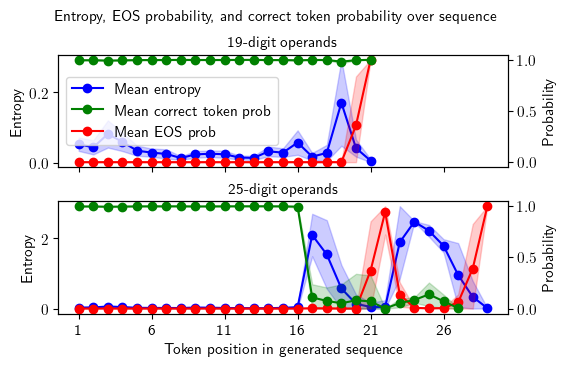

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(5.8, 3.5), sharex=True)

n_samples = 100

plot(ax1, digit_length=19, n_samples=n_samples, xlabel=False, legend=True)
plot(ax2, digit_length=25, n_samples=n_samples, xlabel=True, legend=False)

fig.suptitle("Entropy, EOS probability, and correct token probability over sequence")
plt.subplots_adjust(hspace=0.3, top=0.85)
plt.savefig(
    f"../latex/fig/next_token_entropy.png",
    dpi=300,
    bbox_inches="tight",
)